In [1]:
paths = [".."]
import sys
for path in paths:
    if path not in sys.path:
        sys.path.append(path)
from nf_slam.lidar_dataset_loader import LidarDatasetLoader, LidarDatasetLoaderConfig
from nf_slam.space_hashing_mapping.map_model import MapModelConfig, MapModel
from nf_slam.space_hashing_mapping.mlp_model import MLPModel
from nf_slam.space_hashing_mapping.mapping import LearningConfig, OptimizerConfig, MapBuilder, ScanData,\
    init_map_model, BuildMapResult, depth_prediction_loss_function
from nf_slam.plotting_utils import show_points, plot_nf_with_scans, plot_optimization_result,\
    plot_model_heatmap
from nf_slam.tracking.tracking import OptimizePositionConfig, PositionOptimizer, OptimizePositionResult, \
    OptimizePositionState
from nf_slam.position_2d import Position2D
import matplotlib.pyplot as plt
import jax.numpy as jnp
import numpy as np
import tqdm
import matplotlib.animation
import io
plt.rcParams["animation.html"] = "jshtml"
plt.rcParams["animation.embed_limit"] = 150
import jax
import flax.linen as nn
import functools
import jax_dataclasses as jdc
import flax
import dataclasses
from nf_slam.space_hashing_mapping.mapping import ScanData, LearningData, predict_depths
from flax.optim import Adam
import numpy as np

ROS is not sourced. To enable ROS features, please source it


# Load dataset

In [2]:
lidar_dataset_loader_config = LidarDatasetLoaderConfig(
    maximal_token_length=180,
    minimal_angle=90.,
    maximal_angle=90.,
    maximal_distance=10.
)
dataset_loader = LidarDatasetLoader(lidar_dataset_loader_config)

In [3]:
datafile = "/home/mikhail/Downloads/intel.gfs(4).log" 
laser_data_list = dataset_loader.load(datafile)

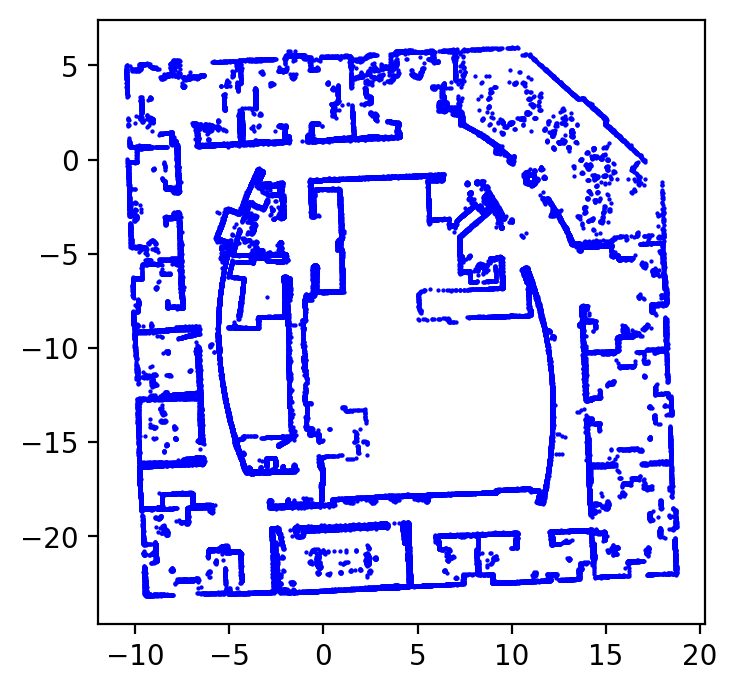

In [4]:
plt.figure(dpi=200)
show_points(laser_data_list[0:1000:2], c="blue");

# Space hashing

In [5]:
@jax.jit
def hashfunction(x, T):
    pi1 = 1
    pi2 = 19349663
    pi3 = 83492791
    result = jnp.bitwise_xor(x[:, 0] * pi1, x[:, 1] * pi2)
    return result % T

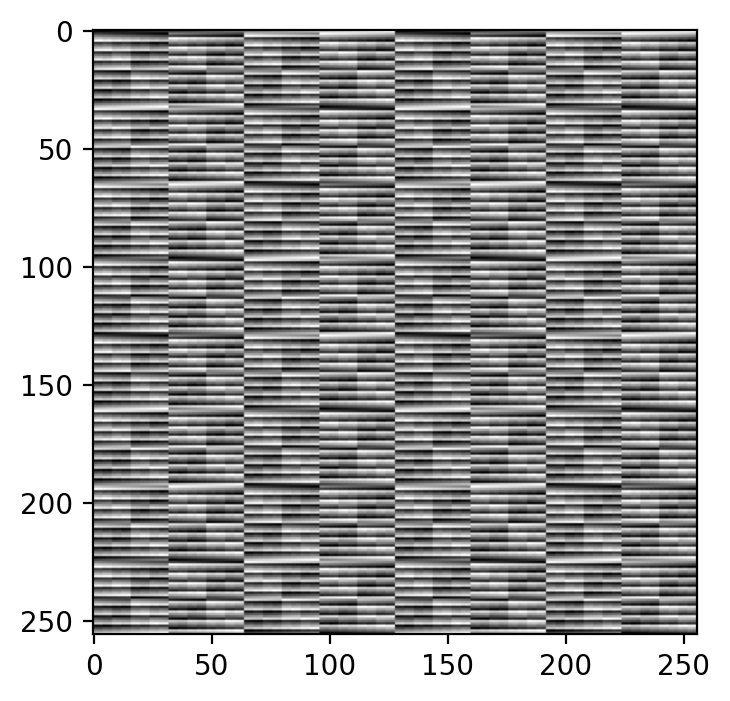

In [6]:
x, y = jnp.meshgrid(jnp.arange(256), jnp.arange(256))
points = jnp.stack([x, y], axis=2)
values = hashfunction(points.reshape(-1, 2), 128).reshape(256, 256)
plt.figure(dpi=200)
plt.imshow(values, cmap="gray")

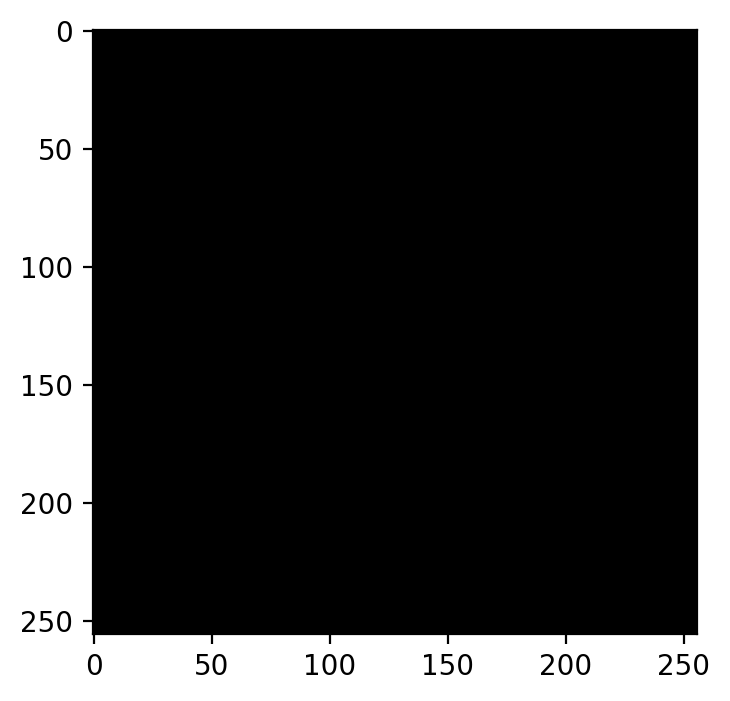

In [7]:
random_reindex = np.random.choice(np.arange(1024), 1024, replace=False)
random_reindex = jnp.array(random_reindex)
plt.figure(dpi=200)
plt.imshow(random_reindex[values] == 30, cmap="gray")

# Train hashtabel

In [8]:
map_model_config = MapModelConfig(
    minimal_depth=0.05,
    maximal_depth=10,
    bins_count=60,
    density_scale=0.5,
    variance_weight=0.1,
    F=4,
    L=32,
    T=4096,
    min_log_resolution=-4,
    max_log_resolution=1.
)
learning_config = LearningConfig(
    iterations=100,
    variable_optimizer_config=OptimizerConfig(
        learning_rate=1e-2,
        beta1=0.9,
        beta2=0.99,
        eps=1e-15,
        weight_decay=1e-6,
    ),
    hashtable_optimizer_config=OptimizerConfig(
        learning_rate=2e-2,
        beta1=0.9,
        beta2=0.99,
        eps=1e-15,
        weight_decay=0,
    )
)
mlp_model = MLPModel()
map_model = init_map_model(mlp_model, map_model_config)

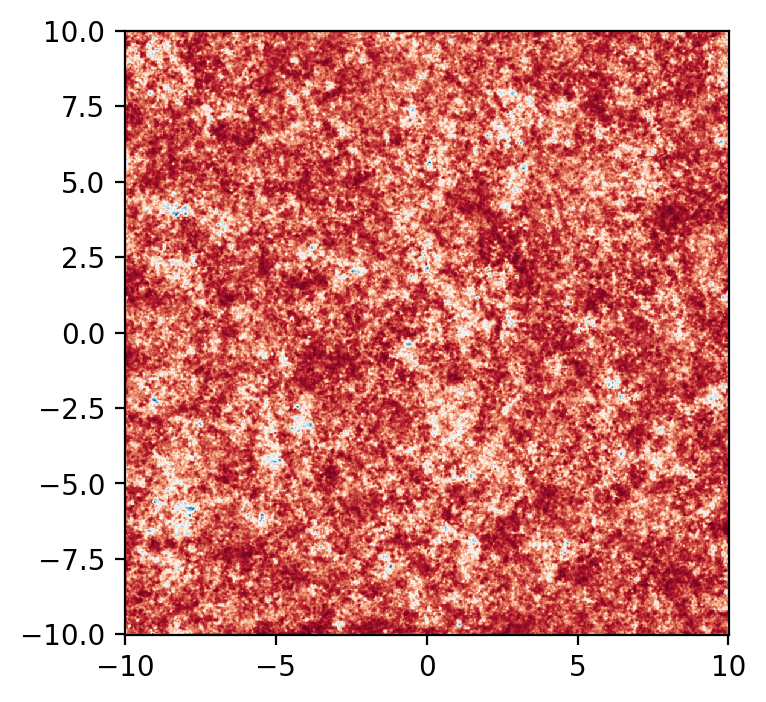

In [9]:
plt.figure(dpi=200)
bounds = (-10, 10, -10, 10)
plot_model_heatmap(map_model, bounds, mlp_model, grid_shape=(1000, 1000))

# Model training

In [26]:
map_model_config = MapModelConfig(
    minimal_depth=0.05,
    maximal_depth=10,
    bins_count=60,
    density_scale=0.5,
    variance_weight=0.1,
    F=4,
    L=32,
    T=4096,
    min_log_resolution=-4,
    max_log_resolution=1.
)
learning_config = LearningConfig(
    iterations=100,
    variable_optimizer_config=OptimizerConfig(
        learning_rate=1e-2,
        beta1=0.9,
        beta2=0.99,
        eps=1e-15,
        weight_decay=1e-6,
    ),
    hashtable_optimizer_config=OptimizerConfig(
        learning_rate=2e-2,
        beta1=0.9,
        beta2=0.99,
        eps=1e-15,
        weight_decay=0,
    )
)
mlp_model = MLPModel()
map_builder = MapBuilder(learning_config, map_model_config, mlp_model)

learning_index = 50
laser_data = laser_data_list[learning_index]
map_position = jnp.array(laser_data.odometry_position.as_vec())
map_builder_result = map_builder.build_map(laser_data, map_position)

Compilation take 3.513101816177368 s


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 37.97it/s]


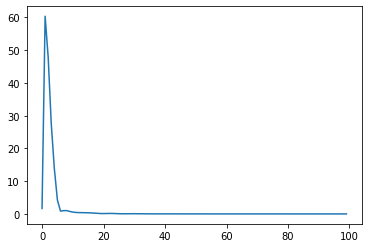

In [27]:
plt.plot(map_builder_result.loss_history)

In [28]:
def plot_reconstructed_result(laser_data, model_config, mlp_model, map_model, s=3, c="blue"):
    scan_data = ScanData.from_laser_data(laser_data)
    position = jnp.array(laser_data.odometry_position.as_vec())
    learning_data = LearningData(uniform=jnp.ones((len(scan_data.depths), model_config.bins_count)) * 0.5)
    predicted_depths = predict_depths(map_model, position, scan_data, learning_data, model_config, mlp_model)
    points = np.stack([np.cos(scan_data.angles) * predicted_depths, np.sin(scan_data.angles) * predicted_depths],
                          axis=1)
    points = laser_data.odometry_position.apply(points)
    plt.scatter(points[:, 0], points[:, 1], s=s, c=c)

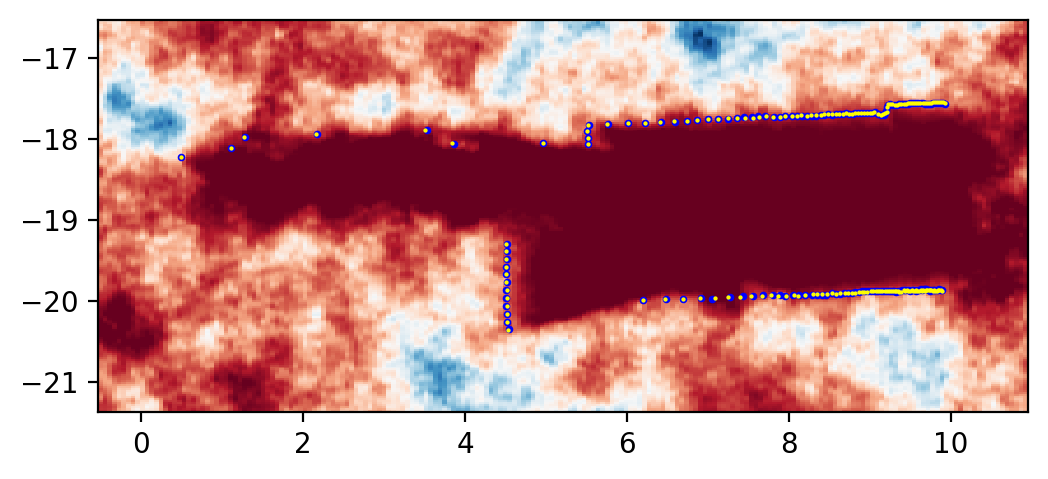

In [29]:
plt.figure(dpi=200)
plot_nf_with_scans(laser_data_list[learning_index:learning_index + 1], map_builder_result.map_model, mlp_model)

plot_reconstructed_result(laser_data_list[learning_index], map_model_config, mlp_model, 
                          map_builder_result.map_model, s=3)
show_points(laser_data_list[learning_index:learning_index + 1], c="yellow");

In [30]:
# plt.figure(dpi=200)
# scan_index = learning_index
# scan_data = ScanData.from_laser_data(laser_data_list[scan_index])
# learning_data = LearningData(uniform=jnp.ones((1, map_model_config.bins_count)) * 0.5)
# small_scan_data = ScanData(
#     depths=scan_data.depths[scan_index:scan_index + 1],
#     angles=scan_data.angles[scan_index:scan_index + 1]
# )
# depth_bins = sample_depth_bins(learning_data, config)
# # depths = (depth_bins[..., 1:] + depth_bins[..., :-1]) / 2
# depths = depth_bins[..., 1:]
# depth_deltas = (depth_bins[..., 1:] - depth_bins[..., :-1]) / 2
# points = calculate_points(depths, small_scan_data)
# points = transform_points(points, position).reshape(-1, 2)
# densities = config.density_scale * calculate_densities(points, map_model, model, config.L).reshape(depths.shape[:2])
# weights = jax.vmap(calculate_weights)(densities, depth_deltas)
# extended_depths = jnp.concatenate([depths, jnp.full([depths.shape[0], 1], config.maximal_depth)], axis=-1)
# plt.plot(depths[0], densities[0])
# plt.plot(extended_depths[0], weights[0] * 50)
# # weights = jax.vmap(calculate_weights)(densities, depth_deltas)
# # extended_depths = jnp.concatenate([depths, jnp.full([depths.shape[0], 1], config.maximal_depth)], axis=-1)

# Optimize on several images

In [31]:
@dataclasses.dataclass
class DataPointBatch(object):
    depths: jnp.array
    angles: jnp.array
    x: jnp.array
    y: jnp.array
    angle: jnp.array
        
    @property
    def scan_data(self):
        return ScanData(depths=self.depths, angles=self.angles)

    @property
    def position(self):
        return jnp.stack([self.x, self.y, self.angle], axis=1)

In [32]:
def get_random_data_point_batch(laser_data_list, laser_data_indeces, scan_count, points_per_scan):
    laser_data_indeces = np.random.choice(laser_data_indeces, scan_count, replace=False)
    scan_point_indeces = np.random.choice(np.arange(180), (scan_count, points_per_scan))
    depths = []
    angles = []
    x = []
    y = []
    angle = []
    for i in range(scan_count):
        laser_data = laser_data_list[laser_data_indeces[i]]
        scan_point_index = scan_point_indeces[i]
        mask = laser_data.ranges[scan_point_index] < 10
        indeces = np.arange(mask.shape[0])[mask]
        indeces = np.random.choice(indeces, points_per_scan)
        depths.extend(list(laser_data.ranges[scan_point_index][indeces]))
        angles.extend(list(laser_data.angles[scan_point_index][indeces]))
        x.extend(list(np.full(indeces.shape[0], laser_data.odometry_position.x)))
        y.extend(list(np.full(indeces.shape[0], laser_data.odometry_position.y)))
        angle.extend(list(np.full(indeces.shape[0], laser_data.odometry_position.rotation)))
    return DataPointBatch(
        depths = jnp.array(depths),
        angles = jnp.array(angles),
        x = jnp.array(x),
        y = jnp.array(y),
        angle = jnp.array(angle)
    )

In [33]:
grad_function = jax.jit(jax.value_and_grad(depth_prediction_loss_function), static_argnums=[4, 5])
max_laser_data_index = 910
laser_data_indices = np.arange(max_laser_data_index)
iterations = 1000 * 5
map_model =  init_map_model(mlp_model, map_model_config)
variable_optimizer = Adam(1e-2, beta1=0.9, beta2=0.99, eps=1e-15, weight_decay=1e-6)
variable_state = variable_optimizer.init_state(map_model.variables)
hashtable_optimizer = Adam(2e-2, beta1=0.9, beta2=0.99, eps=1e-15)
hashtable_state = hashtable_optimizer.init_state(map_model.hashtable)

loss_history = []

for i in tqdm.tqdm(range(iterations)):
    batch = get_random_data_point_batch(laser_data_list, laser_data_indices, 20, 100)
    scan_data = batch.scan_data
    position = batch.position
    learning_data = LearningData(uniform=jax.random.uniform(jax.random.PRNGKey(i), 
        (len(scan_data.depths), map_model_config.bins_count)))
    loss, grad = grad_function(map_model, position, scan_data, learning_data, map_model_config, mlp_model)
    loss_history.append(loss)
    variables, variable_state = hashtable_optimizer.apply_gradient(variable_optimizer.hyper_params, 
                                                                   map_model.variables,
                                                           variable_state, grad.variables)
    hashtable, hashtable_state = hashtable_optimizer.apply_gradient(hashtable_optimizer.hyper_params, 
                                                                    map_model.hashtable, 
                                                          hashtable_state, grad.hashtable)
    map_model = MapModel(hashtable=hashtable, variables=variables, resolutions=map_model.resolutions,
                         origins=map_model.origins, rotations=map_model.rotations)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [10:07<00:00,  8.22it/s]


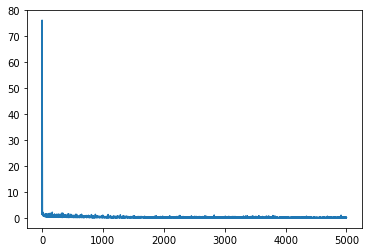

In [34]:
plt.plot(loss_history)

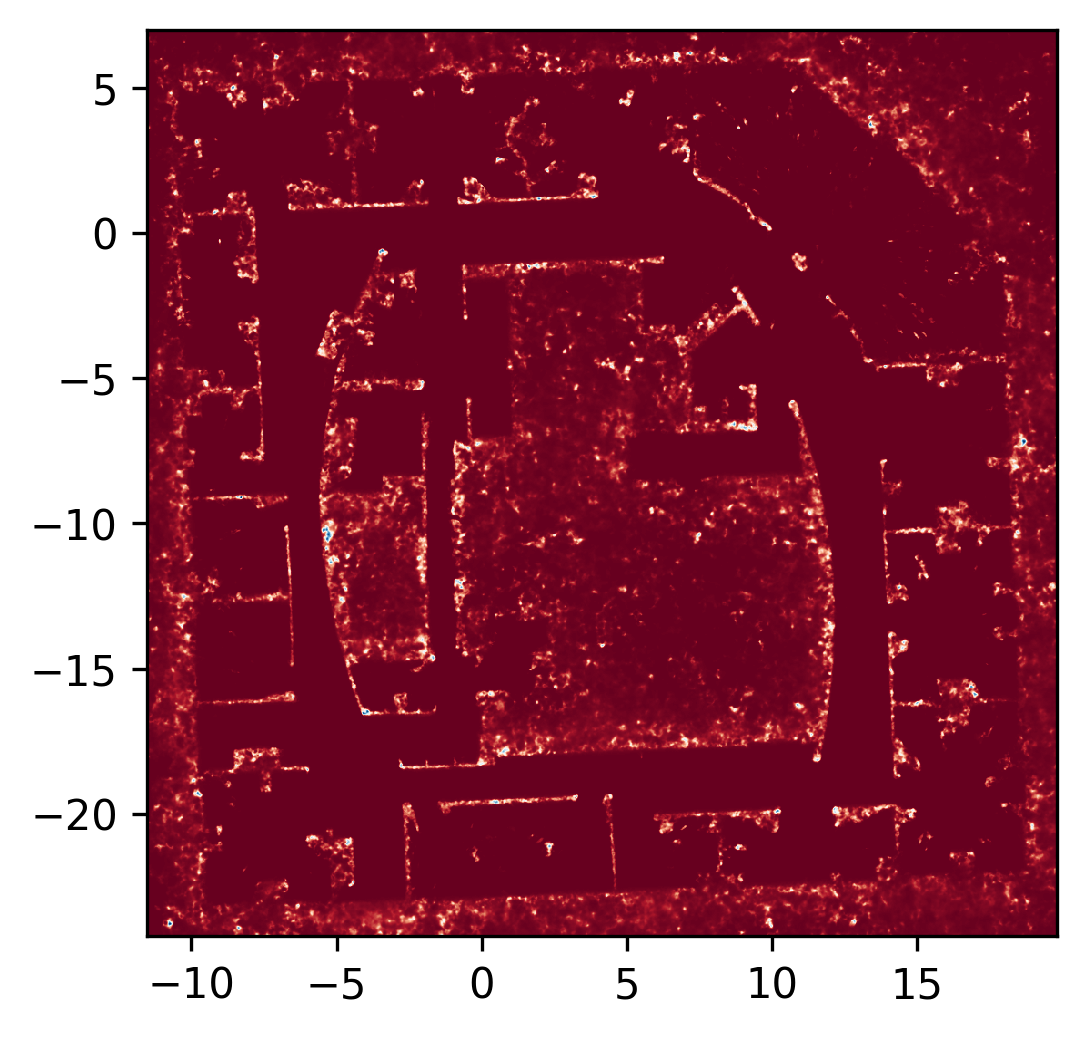

In [53]:
plt.figure(dpi=300)
min_layer = 0
max_layer = 32
min_index = 0
max_index = 910
new_hashtable = jnp.concatenate([jnp.zeros((min_layer, map_model_config.T, map_model_config.F)), 
                                 map_model.hashtable[min_layer:max_layer],
                                 jnp.zeros((map_model_config.L - max_layer,  map_model_config.T, map_model_config.F))], 
                                axis=0)
new_origins = jnp.concatenate([map_model.origins[:13] + jnp.array([0, 0]), map_model.origins[13:] ], axis=0)
new_map_model = MapModel(hashtable=new_hashtable, variables=map_model.variables, resolutions=map_model.resolutions,
                        origins=new_origins, rotations=map_model.rotations)

# plot_reconstructed_result(laser_data_list[learning_index], map_model_config, mlp_model, 
#                           map_builder_result.map_model, s=3)
points = show_points(laser_data_list[min_index:max_index])
bounds = (np.min(points[:, 0]) - 1, np.max(points[:, 0]) + 1, np.min(points[:, 1]) - 1, np.max(points[:, 1]) + 1)
plot_model_heatmap(new_map_model, bounds, mlp_model, grid_shape=(1000, 1000), angle=np.pi/2)
# show_points(laser_data_list[min_index:max_index], c="yellow", s=0.1);

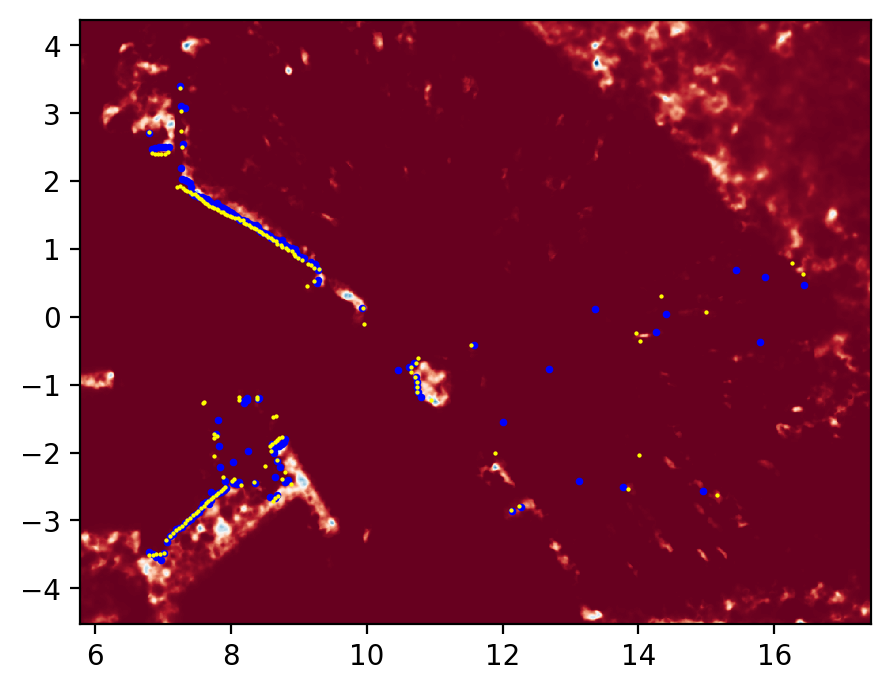

In [55]:
plt.figure(dpi=200)
index = 17
# plot_nf_with_scans(laser_data_list[index:index + 1], new_map_model, mlp_model)

points = show_points(laser_data_list[index:index + 1])
bounds = (np.min(points[:, 0]) - 1, np.max(points[:, 0]) + 1, np.min(points[:, 1]) - 1, np.max(points[:, 1]) + 1)
plot_model_heatmap(new_map_model, bounds, mlp_model, grid_shape=(1000, 1000), angle=-np.pi/2)

plot_reconstructed_result(laser_data_list[index], map_model_config, mlp_model, 
                          new_map_model, s=3)
show_points(laser_data_list[index:index + 1], c="yellow");

(-2.0, 0.0)

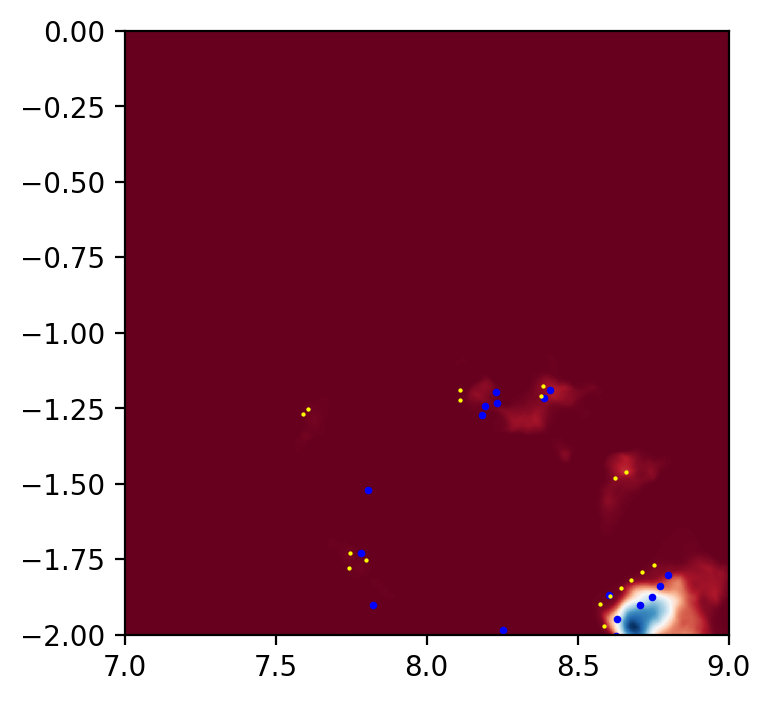

In [56]:
plt.figure(dpi=200)
index = 17
# plot_nf_with_scans(laser_data_list[index:index + 1], new_map_model, mlp_model)

points = show_points(laser_data_list[index:index + 1])
bounds = (np.min(points[:, 0]) - 1, np.max(points[:, 0]) + 1, np.min(points[:, 1]) - 1, np.max(points[:, 1]) + 1)
bounds = (7, 9, -2, 0)
plot_model_heatmap(new_map_model, bounds, mlp_model, grid_shape=(1000, 1000), angle=-np.pi / 4)

plot_reconstructed_result(laser_data_list[index], map_model_config, mlp_model, 
                          new_map_model, s=3)
show_points(laser_data_list[index:index + 1], c="yellow");
plt.xlim(bounds[0], bounds[1])
plt.ylim(bounds[2], bounds[3])

In [ ]:
map_model.variables["params"]["Dense_0"]["kernel"][:-2]

In [ ]:
plt.figure(dpi=200)
scan_index = 30
extended_config = ModelConfig(
    minimal_depth=0.05,
    maximal_depth=10,
    bins_count=60,
    density_scale=0.5,
    variance_weight=3,
    F=32,
    L=4,
    T=2048,
    min_log_resolution=-4,
    max_log_resolution=1.
)
learning_data = LearningData(uniform=jnp.ones((1, extended_config.bins_count)) * 0.5)
small_scan_data = ScanData(
    depths=scan_data.depths[scan_index:scan_index + 1],
    angles=scan_data.angles[scan_index:scan_index + 1]
)
depth_bins = sample_depth_bins(learning_data, config)
# depths = (depth_bins[..., 1:] + depth_bins[..., :-1]) / 2
depths = depth_bins[..., 1:]
depth_deltas = (depth_bins[..., 1:] - depth_bins[..., :-1]) / 2
points = calculate_points(depths, small_scan_data)
points = transform_points(points, position).reshape(-1, 2)
densities = config.density_scale * calculate_densities(points, map_model, model, extended_config.L).reshape(depths.shape[:2])
weights = jax.vmap(calculate_weights)(densities, depth_deltas)
extended_depths = jnp.concatenate([depths, jnp.full([depths.shape[0], 1], config.maximal_depth)], axis=-1)
plt.plot(depths[0], densities[0])
plt.plot(extended_depths[0], weights[0] * 150)
# weights = jax.vmap(calculate_weights)(densities, depth_deltas)
# extended_depths = jnp.concatenate([depths, jnp.full([depths.shape[0], 1], config.maximal_depth)], axis=-1)